In [20]:
#Libraries
using Gen
using PyPlot
using Distributions
using LinearAlgebra
using Flux
using Random
using Distances
using Genify
include("hmc_mod.jl")
include("helper_functions.jl")
include("rj_proposals.jl")
include("NUTS.jl");

┌ Info: Precompiling Genify [bc757091-8f9c-4e02-8109-c8551f70438e]
└ @ Base loading.jl:1260
  ** incremental compilation may be fatally broken for this module **

  ** incremental compilation may be fatally broken for this module **



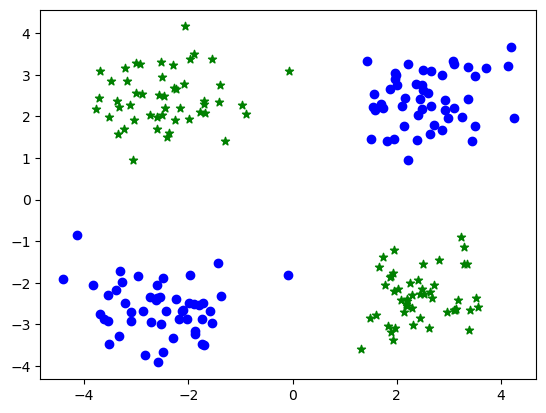

(2, 200)

In [2]:
#------------------------------------
#Hyperparameters and Helper Functions
#------------------------------------

#Select Network Goal
network = "classifier"
#network = "interpolator"

#Data hyperparameters
n = 50 #Number of samples per mode (classifier)
m = 4 #Number of modes (classifier)
d = 2 #Input dimension
N = n*m #Total samples
bound = 2.5 #XOR mode locations
σₐ = 0.5 #Mode variance (classifier)

σ₁ = 3.0#1/τ₁
σ₂ = 3.0#1/τ₂
σ₃ = 30.0#1/τ₃

#Network hyperparameters
α = 6 #Gamma Scale for Hyperparameters

#Node hyperparameters
k_range = 4 #Maximum number of neurons per layer
#k_list = [Int(i) for i in 1:k_range]
k_list = zeros(k_range)
k_list[k_range] = 1.0
k_real = k_range

#Layer hyperparameters
l_range = 2 #Maximum number of layers in the network
#l_list = [Int(i) for i in 1:l_range]
l_list = zeros(k_range)
l_list[l_range] = 1.0
l_real = l_range

#NUTS
Δmax = 1000;

#Data
x_raw, classes = real_data_classifier(Int(N/4), m, bound, σₐ);
classes = [(i+1) % 2 + 1 for i in classes]
y_real = classes

plot_data_classifier(x_raw,classes)
x = transpose(x_raw)
size(x)

In [19]:
@gen function classifier()
    u = [(uniform(-100,100)) for i=1:10]
    t = @trace([(uniform(-100,100)) for i=1:10],:t)
end

LoadError: syntax error in @trace at [uniform(-100, 100) for i = 1:10]

DynamicDSLFunction{Any}(Dict{Symbol,Any}(), Dict{Symbol,Any}(), Type[Int64], false, Union{Nothing, Some{Any}}[nothing], Genify.TracedFunction{Tuple{Int64}}(uni, Genify.Options{true,true,:static}()), Bool[0], false)

In [41]:
trace = simulate(multi_u, (12,))
get_choices(trace)


trace[(:u => 2)]

@gen function weights()
    w1 = @trace(multi_u(12),:w1)
end

trace2 = simulate(weights, (),)
trace2[:w1]

12-element Array{Float64,1}:
   2.223132811037061
  -0.4880979243180832
  11.59630958806845
 -72.90982981904529
 -40.44774557576023
 -55.18748719603437
 -69.19166775442127
  60.716046886475795
 -41.275832892484665
 -12.82206450110968
 -17.200505761276787
 -92.76064651066677

In [61]:
#Bayesian Neural Net
function G(x, trace)
    activation = σ
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], 1, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

function uni(n::Int)
    obs = Float64[]
    for i in 1:n
        u = rand(Uniform(-10,10))
        push!(obs, u)
    end
    return obs
end

multi_u = genify(uni, Int)

#Uniform
@gen function classifier2(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            μ = zeros(h)
            W[i] = @trace(multi_u(h),(:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            μ2 = zeros(k[i])
            b[i] = @trace(multi_u(k[i]),(:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            μₒ = zeros(k[l])
            W[i] = @trace(multi_u(k[l]),(:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            μ2ₒ = zeros(1)
            b[i] = @trace(multi_u(1),(:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    y = scores
    for j=1:N
        y[j] = @trace(categorical([1-scores[j],scores[j]]), (:y,j))
    end

    return scores
    
end;

obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master;

(trace,) = generate(classifier2, (x,), obs)

test_scores = classifier2(x)
test_labels = data_labeller(test_scores)
test_acc = sum([classes[i] == test_labels[i] for i=1:length(classes)])

get_score(trace)

-1396.4951616217982

In [64]:
#Bayesian Neural Net
function G(x, trace)
    activation = σ
    layers = trace[:l]
    ks = [trace[(:k,i)] for i=1:layers]
    for i=1:layers
        in_dim, out_dim = layer_unpacker(i, layers, ks)
        W = reshape(trace[(:W,i)], out_dim, in_dim)
        b = reshape(trace[(:b,i)], trace[(:k,i)])
        nn = Dense(W, b, activation)
        x = nn(x)
    end
    
    Wₒ = reshape(trace[(:W,layers+1)], 1, ks[layers])
    bₒ = reshape(trace[(:b,layers+1)], 1)
    
    nn_out = Dense(Wₒ, bₒ)
    return nn_out(x)
end;

#MvNormal
@gen function classifier(x::Array{Float64})
    
    #Create a blank choicemap
    obs = choicemap()::ChoiceMap
    
    #Draw number of layers
    l ~ categorical([1/length(l_list) for i=1:length(l_list)])
    l_real = l
    obs[:l] = l
    
    #Create individual weight and bias vectors
    #Loop through hidden layers
    k = [Int(0) for i=1:l+1]
    for i=1:l
        k[i] = @trace(categorical([1/length(k_list) for i=1:length(k_list)]), (:k,i))
        obs[(:k,i)] = k[i]
    end
    k[l+1] = @trace(categorical([1.0]), (:k,l+1))
    obs[(:k,l+1)] = k[l+1]
    
    #Standard Deviations
    σ₁ = 3.0#1/τ₁
    σ₂ = 3.0#1/τ₂
    σ₃ = 30.0#1/τ₃
    
    #Sample weight and parameter vectors
    W = [zeros(k[i]) for i=1:l+1]
    b = [zeros(k[i]) for i=1:l+1]
    for i=1:l+1
        if i == 1
            h = Int(d * k[i])
        else
            h = Int(k[i-1] * k[i])
        end

        if i<=l
            #Hidden Weights
            μ = zeros(h)
            Σ = Diagonal([σ₁ for i=1:length(μ)])
            W[i] = @trace(mvnormal(μ,Σ), (:W,i))
            obs[(:W,i)] = W[i]
            
            #Hidden Biases
            μ2 = zeros(k[i])
            Σ2 = Diagonal([σ₁ for i=1:length(μ2)])
            b[i] = @trace(mvnormal(μ2,Σ2), (:b,i))
            obs[(:b,i)] = b[i]
        else
            #Output Weights
            μₒ = zeros(k[l])
            Σₒ = Diagonal([σ₁ for i=1:length(μₒ)])
            W[i] = @trace(mvnormal(μₒ,Σₒ), (:W,i))
            obs[(:W,i)] = W[i]

            #Output Bias
            μ2ₒ = zeros(1)
            Σ2ₒ = Diagonal([σ₁ for i=1:length(μ2ₒ)])
            b[i] = @trace(mvnormal(μ2ₒ,Σ2ₒ), (:b,i))
            obs[(:b,i)] = b[i]
        end
    end
    
    #Return Network Scores for X
    scores = G(x,obs)
    scores = Flux.σ.(scores)
    
    #Logistic Regression Likelihood
    y = scores
    for j=1:N
        y[j] = @trace(categorical([1-scores[j],scores[j]]), (:y,j))
    end

    return scores
    
end;

obs_master = choicemap()::ChoiceMap
for i=1:length(classes)
    obs_master[(:y,i)] = classes[i]
end
obs = obs_master;

@time (trace,) = generate(classifier, (x,), obs)
#println(best_trace[:τ₁])
#println(best_trace[:τ₂])
#println(best_trace[:τ₃])

test_scores = classifier(x)
test_labels = data_labeller(test_scores)
test_acc = sum([classes[i] == test_labels[i] for i=1:length(classes)])

  0.440048 seconds (1.07 M allocations: 54.235 MiB, 5.78% gc time)


100

In [63]:
(trace,) = generate(classifier2, (x,), obs)
selection = select_selection(trace)
traces = []
accs = []
iters = 500
for i = 1:iters
    (new_trace, hmc_score) = hmc_mod(trace, trace, selection, L=1, eps=1.5, check=false, observations=obs)
    #println(hmc_score)
    if log(rand()) < hmc_score
        trace = new_trace
        push!(accs, 1.0)
    else
        push!(accs, 0.0)
    end
    push!(traces, trace)
    if i%50 == 0
        println("Epoch $i Acceptance Prob: $(sum(accs)/length(accs))")
    end
end

ErrorException: Gradient required but not available for return value of distribution Genify.WrappedDistribution{Float64,Uniform{Float64}}(Uniform{Float64}(a=-10.0, b=10.0))

In [ ]:
(trace,) = generate(classifier, (x,), obs)
selection = select_selection(trace)
traces = []
accs = []
iters = 5
for i = 1:iters
    (new_trace, hmc_score) = NUTS(trace, selection, false, obs, 1, 1, trace)
    #println(hmc_score)
    if log(rand()) < hmc_score
        trace = new_trace
        push!(accs, 1.0)
    else
        push!(accs, 0.0)
    end
    push!(traces, trace)
    if i%5 == 0
        println("Epoch $i Acceptance Prob: $(sum(accs)/length(accs))")
    end
end

In [ ]:
scores = [get_score(trace) for trace in traces]
plot(scores)

In [ ]:
accs = []
for i=1:length(traces)
    trace = traces[i]
    pred_y = G(x,trace)
    pred_labels = data_labeller(pred_y)
    
    acc = sum([classes[i] == pred_labels[i] for i=1:length(classes)])
    push!(accs,acc)
end

plot(accs)
println(sum(accs)/length(accs))
plt.title("RJMCMC Accuracy: XOR Classifier")
plt.xlabel("Iteration")
plt.ylabel("# Classified Correctly (out of 200)");

In [ ]:
function plot_grid(data,scores,alpha=1.0)
    PyPlot.scatter(data[:,1],data[:,2],c=scores,alpha=alpha,cmap="PRGn")
    #PyPlot.colorbar()
end

function tracegrid(traces, samples=100, low=-5.0, high=5.0)
    d=2
    n=100
    r = range(low, high, length = n)
    
    iter = Iterators.product((r for _ in 1:d)...)
    grid= vec([collect(i) for i in iter])
    grid_raw = reduce(hcat, getindex.(grid,i) for i in eachindex(grid[1]))
    grid2 = transpose(grid_raw)
    z_master = zeros(length(grid2[1,:]))
    
    for i=1:samples
        j = rand((400,length(traces)))
        trace = traces[j]
        z = Flux.σ.(G(grid2,trace))[1,:]
        z_master += (z ./ samples)
    end
    plot_grid(grid_raw, z_master)
end

tracegrid(traces)
plot_data_classifier(x_raw,classes)